In [26]:
import requests
import pandas as pd
import numpy as np
import gzip
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Importando os dados do brasil.io

Link direto: https://data.brasil.io/dataset/covid19/caso.csv.gz

Particularidades do dataset:

- campo place_type possui o seguinte domínio:
    - state (Estado)
    - city (Cidade)

In [2]:
CSV_URL = 'https://data.brasil.io/dataset/covid19/caso.csv.gz'

df = pd.read_csv(CSV_URL, compression='gzip',
                   error_bad_lines=False)

In [3]:
# Formatando coluna date para datetime
# Referência: https://strftime.org
df['date'] = pd.to_datetime(df.date, format=r'%Y-%m-%d')

# Limpando dados inválidos
df = df.drop(df[df.city == 'Importados/Indefinidos'].index)

# Separando dados em estados e cidades
df_estados = df[df.place_type=='state']
df_cidades = df[df.place_type=='city']

date
state city              date                 
AC    Acrelândia        2020-03-29 2020-03-29
      Plácido de Castro 2020-04-06 2020-04-06
      Porto Acre        2020-03-29 2020-03-29
      Rio Branco        2020-03-17 2020-03-17
AL    Maceió            2020-03-08 2020-03-08
...                                       ...
SP    Votuporanga       2020-03-31 2020-03-31
      Águas de Lindóia  2020-04-02 2020-04-02
TO    Araguaína         2020-03-27 2020-03-27
      Dianópolis        2020-04-04 2020-04-04
      Palmas            2020-03-18 2020-03-18

[670 rows x 1 columns]

In [52]:
day1.set_index('date', append=True, drop=False).join(df_cidades.set_index(['date', 'state', 'city'])[['confirmed', 'deaths']]).tail(20)

date  confirmed  deaths
state city                   date                                    
SP    São José do Rio Preto  2020-03-18 2020-03-18          1     NaN
      São José dos Campos    2020-03-18 2020-03-18          1     NaN
      São Manuel             2020-04-04 2020-04-04          1     0.0
      São Paulo              2020-02-26 2020-02-26          1     NaN
      São Pedro              2020-03-30 2020-03-30          1     0.0
      São Sebastião          2020-03-25 2020-03-25          2     0.0
      São Vicente            2020-03-31 2020-03-31          1     0.0
      Taboão da Serra        2020-03-25 2020-03-25          1     1.0
      Tatuí                  2020-03-26 2020-03-26          1     0.0
      Taubaté                2020-03-19 2020-03-19          1     NaN
      Terra Roxa             2020-04-05 2020-04-05          1     0.0
      Valinhos               2020-03-25 2020-03-25          1     0.0
      Vargem Grande Paulista 2020-03-19 2020-03-19          1     0.0
      Vinhedo                2020-03-31 2020-03-31          1     0.0
      Votorantim             2020-03-31 2020-03-31          1     0.0
      Votuporanga            2020-03-31 2020-03-31          1     0.0
      Águas de Lindóia       2020-04-02 2020-04-02          1     0.0
TO    Araguaína              2020-03-27 2020-03-27          1     0.0
      Dianópolis             2020-04-04 2020-04-04          1     NaN
      Palmas                 2020-03-18 2020-03-18          1     NaN

In [4]:
# Capturando o menor dia registrado para cada cidade
day1 = pd.DataFrame(df_cidades.groupby(['state', 'city']).min()['date'])

# Incluindo no dataset o primeiro dia em cada linha
if 'date_day1' not in df_cidades.columns:
    df_cidades = df_cidades.join(day1, on=['state', 'city'], rsuffix='_day1')

    

# Calculando quantidade de dias desde o primeiro dia em cada cidade
df_cidades['t_delta'] = (df_cidades['date'] - df_cidades['date_day1']).apply(lambda x: x.days)

In [5]:
pd.DataFrame(df_cidades.groupby(['city']).max()['confirmed_per_100k_inhabitants'])

,confirmed_per_100k_inhabitants
city,
Abaetetuba,0.63412
Abaiara,8.52006
Acrelândia,58.99318
Adamantina,2.85160
Adustina,5.86854
...,...
Votuporanga,3.17303
Várzea Grande,1.75456
Águas Lindas de Goiás,0.47072


In [23]:
yesterday = datetime.today() - timedelta(days=1)
yesterday = datetime(yesterday.year, yesterday.month, yesterday.day)

top10 = df_cidades[df_cidades.date == yesterday].sort_values('deaths', ascending=False, ignore_index=True)[['state', 'city', 'deaths', 'date']].head(10)
top10

,state,city,deaths,date
0,SP,São Paulo,244.0,2020-04-06
1,RJ,Rio de Janeiro,47.0,2020-04-06
2,PE,Recife,16.0,2020-04-06
3,AM,Manaus,11.0,2020-04-06
4,DF,Brasília,10.0,2020-04-06
5,BA,Salvador,8.0,2020-04-06
6,SP,Guarulhos,6.0,2020-04-06
7,RS,Porto Alegre,5.0,2020-04-06
8,SP,São Bernardo do Campo,5.0,2020-04-06
9,GO,Goiânia,4.0,2020-04-06


In [18]:
for state, city in top10[['state', 'city']].itertuples(index=False):
    print(state, city)

SP São Paulo
RJ Rio de Janeiro
PE Recife
AM Manaus
DF Brasília
BA Salvador
SP Guarulhos
RS Porto Alegre
SP São Bernardo do Campo
GO Goiânia


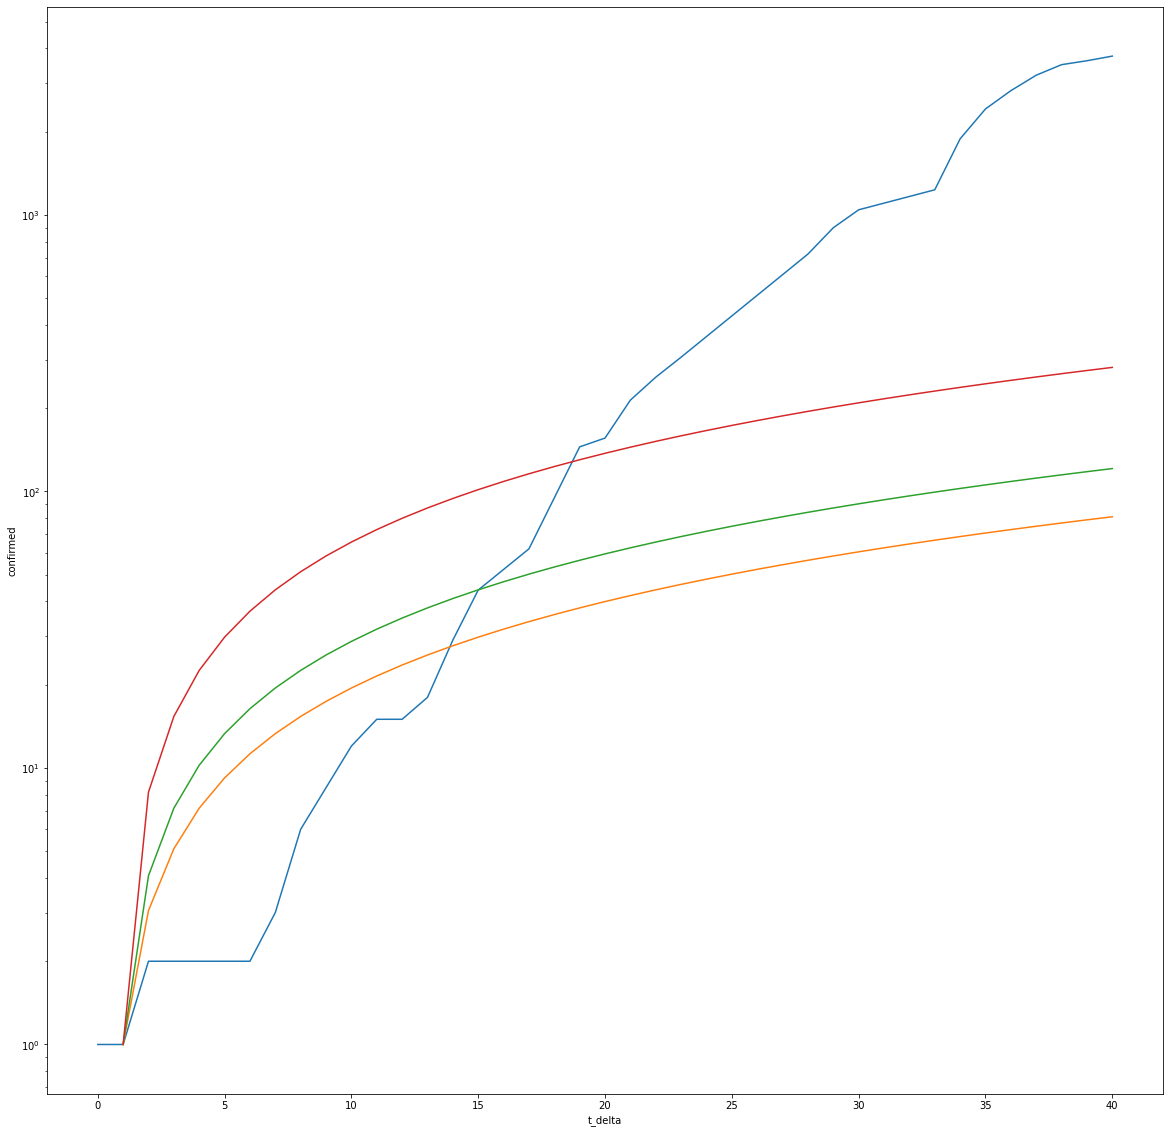

In [60]:
plt.figure(figsize=(20,20))

sns.lineplot(x='t_delta', y='confirmed', data=df_cidades[df_cidades.city=='São Paulo'])

sns.lineplot(np.linspace(1,max(df_cidades.t_delta),40), 2*np.linspace(0,max(df_cidades.t_delta),40)+1)
sns.lineplot(np.linspace(1,max(df_cidades.t_delta),40), 3*np.linspace(0,max(df_cidades.t_delta),40)+1)
sns.lineplot(np.linspace(1,max(df_cidades.t_delta),40), 7*np.linspace(0,max(df_cidades.t_delta),40)+1)

plt.yscale('log')

No handles with labels found to put in legend.


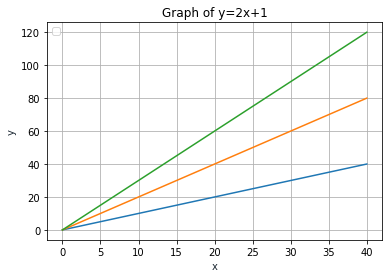

In [46]:
import matplotlib.pyplot as plt
import numpy as np
x = np.linspace(0,max(df_cidades.t_delta),100)
y = 2*x
sns.lineplot(x, x)
sns.lineplot(x, 2*x)
sns.lineplot(x, 3*x)
plt.title('Graph of y=2x+1')
plt.xlabel('x', color='#1C2833')
plt.ylabel('y', color='#1C2833')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [29]:
df_cidades[df_cidades.city=='São Paulo']

,date,state,city,place_type,confirmed,deaths,order_for_place,is_last,estimated_population_2019,city_ibge_code,confirmed_per_100k_inhabitants,death_rate,date_day1,t_delta
3368,2020-04-06,SP,São Paulo,city,3754,244.0,32,True,12252023.0,3550308.0,30.63984,0.0650,2020-02-26,40
3369,2020-04-05,SP,São Paulo,city,3612,220.0,31,False,12252023.0,3550308.0,29.48085,0.0609,2020-02-26,39
3370,2020-04-04,SP,São Paulo,city,3496,212.0,30,False,12252023.0,3550308.0,28.53406,0.0606,2020-02-26,38
3371,2020-04-03,SP,São Paulo,city,3202,186.0,29,False,12252023.0,3550308.0,26.13446,0.0581,2020-02-26,37
3372,2020-04-02,SP,São Paulo,city,2815,164.0,28,False,12252023.0,3550308.0,22.97580,0.0583,2020-02-26,36
3373,2020-04-01,SP,São Paulo,city,2418,144.0,27,False,12252023.0,3550308.0,19.73552,0.0596,2020-02-26,35
3374,2020-03-31,SP,São Paulo,city,1885,121.0,26,False,12252023.0,3550308.0,15.38521,0.0642,2020-02-26,34
3375,2020-03-30,SP,São Paulo,city,1233,103.0,25,False,12252023.0,3550308.0,10.06364,0.0835,2020-02-26,33
3376,2020-03-27,SP,São Paulo,city,1044,62.0,24,False,12252023.0,3550308.0,8.52104,0.0594,2020-02-26,30
3377,2020-03-26,SP,São Paulo,city,899,53.0,23,False,12252023.0,3550308.0,7.33756,0.0590,2020-02-26,29
